In [1]:
.L ../libAmBe.so

In [2]:
test // Check if lib is loaded correcly

(const int) 11


In [3]:
char const* path {"../dataset/ambe2022.root"};
DataSetHolder dataset = ambeDataSet(path);

In [4]:
double totalEvent = dataset.df.Count().GetValue();
totalEvent

(double) 196437.00


In [5]:
ROOT::RDF::RNode df = filterT1Events(dataset.df, 10e-6)
    .Filter("is_event", "T1 Filter");

# First cut
4.44 gamma event created

In [6]:
double T1Event = df.Count().GetValue();
T1Event

(double) 119061.00


In [7]:
 T1Event * 100. / totalEvent

(double) 60.610272


# Second cut
Gamma 4.44 reach detector && CE e^- above 4 MeV reach the detector

In [8]:
ROOT::RDF::RNode df2 = df.Define(
    "chainMaskT9",
    "decayChainMask(T9.parentid, T9.trackid, T9.pdg, T9.CreatorProcessID, T9.initialEkin)"
);
df2 = createT5Mask(df2);
df2 = df2.Redefine(
    "chainMaskT5",
    "ROOT::VecOps::Where(chainMaskT5==maskNOISE && (pdg == 1000020040 || pdg == 1000010030), ROOT::RVec (chainMaskT5.size(), -1), chainMaskT5)"
);

In [9]:
df2 = df2.Filter("ROOT::VecOps::Any(chainMaskT5 == maskGAMMA)", "Gamma reach pvt")
    .Filter("ROOT::VecOps::Any(chainMaskT5 == maskCE_ELECT)", "CE reach pvt");

In [10]:
double T5Event = df2.Count().GetValue();
T5Event

(double) 41833.000


In [11]:
 T5Event * 100. / totalEvent

(double) 21.295886


In [12]:
df2 = df2.Filter("ROOT::VecOps::Any(T9.initialEkin[chainMaskT9 == maskCE_ELECT] > 4)", "CE produced with Ekin > 4");

In [13]:
double T5Event = df2.Count().GetValue();
T5Event

(double) 11393.000


In [14]:
 T5Event * 100. / totalEvent

(double) 5.7998239


# Third and fourth cut
Gamma event inside only one cube && CE event inside only one cube

For a given Gap

In [15]:
ROOT::RDF::RNode df3 = df2.Define(
    "volidCE",
    "volidEpvtTot(volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD], E_quenched[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])"
);
df3 = df3.Define("edep_pvtCE", "std::get<1>(volidCE)");
df3 = df3.Redefine("volidCE", "std::get<0>(volidCE)");
df3 = df3.Define(
    "volidGamma",
    "volidEpvtTot(volid[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD], E_quenched[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD])"
);
df3 = df3.Define("edep_pvtGamma", "std::get<1>(volidGamma)");
df3 = df3.Redefine("volidGamma", "std::get<0>(volidGamma)");
df3 = df3.Define(
    "volidNeutron",
    "volidEpvtTot(volid[chainMaskT5 == maskNOISE], E_quenched[chainMaskT5 == maskNOISE])"
);
df3 = df3.Define("edep_pvtNeutron", "std::get<1>(volidNeutron)");
df3 = df3.Redefine("volidNeutron", "std::get<0>(volidNeutron)");

In [16]:
df3  = df3.Filter("ROOT::VecOps::Sum(edep_pvtGamma > 0.1) == 1", "1 cube Gamma")
    .Filter("ROOT::VecOps::Sum(edep_pvtCE > 0.1) == 1", "1 cube CE");

In [17]:
double GammaCEEvent = df3.Count().GetValue();
GammaCEEvent

(double) 3858.0000


In [18]:
 GammaCEEvent * 100. / totalEvent

(double) 1.9639885


# Cut five

Gamma <-> CE distance above 1

In [19]:
ROOT::RDF::RNode df4 = df3.Define("GammaEpvtRef", "edep_pvtGamma[edep_pvtGamma > 0.1]");
df4 = df4.Define("GammaVolidRef", "volidGamma[edep_pvtGamma > 0.1]");
df4 = df4.Define("CEEpvtRef", "edep_pvtCE[edep_pvtCE > 0.1]");
df4 = df4.Define("CEVolidRef", "volidCE[edep_pvtCE > 0.1]");

In [20]:
df4 = df4.Define("euclidDistGrefCeref", "euclidDist(CEVolidRef.at(0), GammaVolidRef)");
df4 = df4.Define("zDistGrefCeref", "zDist(CEVolidRef.at(0), GammaVolidRef)");

In [21]:
df4 = df4.Filter("ROOT::VecOps::Any(euclidDistGrefCeref >= 1.)", "Distance >= 1");

In [22]:
df4 = df4.Define("NeutronChainSum", "ROOT::VecOps::Sum(edep_pvtNeutron)");

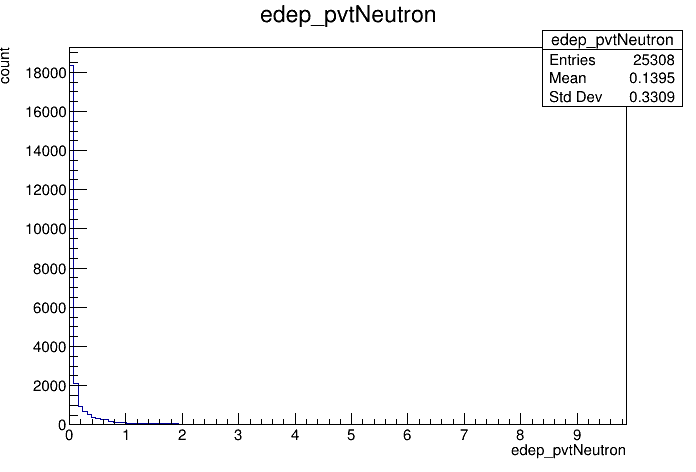

In [23]:
TCanvas c;
auto hist = df4.Histo1D("edep_pvtNeutron")->DrawClone(); //{"NeutronChain", "NeutronChain", 100u, 0., 4.2}
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

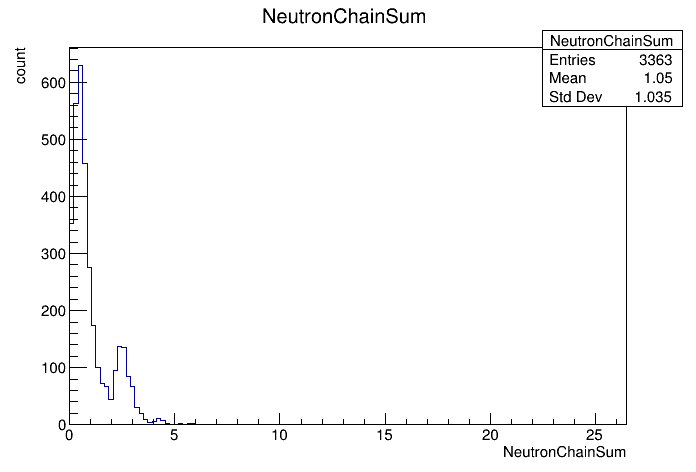

In [24]:
TCanvas c;
auto hist = df4.Histo1D("NeutronChainSum")->DrawClone(); //{"NeutronChain", "NeutronChain", 100u, 0., 4.2}
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [25]:
df4.Display({"chainMaskT5", "E_quenched", "edep_pvt", "pdg"}, 50, 50)->Print()

+------+-------------+---------------+---------------+------------+
| Row  | chainMaskT5 | E_quenched    | edep_pvt      | pdg        | 
+------+-------------+---------------+---------------+------------+
| 17   | 1           | 8.8660187e-06 | 2.0412020e-05 | 22         | 
|      | 1           | 5.0550000e-05 | 0.0000000     | 22         | 
|      | 3           | 6.0040000e-05 | 0.0000000     | 11         | 
|      | 3           | 0.00093991000 | 0.0000000     | 11         | 
|      | 0           | 5.0160000e-05 | 0.0000000     | 22         | 
|      | 0           | 5.7280000e-05 | 0.0000000     | 11         | 
|      | 0           | 2.9990000e-05 | 0.0000000     | 11         | 
|      | 0           | 0.0084344700  | 0.0000000     | 11         | 
|      | 3           | 0.026534936   | 0.0000000     | 11         | 
|      | 3           | 0.0017638516  | 0.0038077605  | 11         | 
|      | 3           | 0.0042983960  | 0.0073821661  | 11         | 
|      | 3           | 0.0059064639 

In [26]:
df4.Display({"chainMaskT9", "T9.initialEkin", "T9.pdg", "T9.parentid", "T9.trackid", "CreatorProcessID"}, 50, 50)->Print()

+------+-------------+----------------+------------+-------------+------------+------------------+
| Row  | chainMaskT9 | T9.initialEkin | T9.pdg     | T9.parentid | T9.trackid | CreatorProcessID | 
+------+-------------+----------------+------------+-------------+------------+------------------+
| 17   | 1           | 4.4400000      | 22         | 0           | 2          | 0                | 
|      | 3           | 6.0040000e-05  | 11         | 2           | 16         | 21               | 
|      | 3           | 0.00093991000  | 11         | 2           | 15         | 21               | 
|      | 0           | 0.0085719000   | 22         | 2           | 14         | 21               | 
|      | 0           | 5.7280000e-05  | 11         | 14          | 19         | 21               | 
|      | 0           | 2.9990000e-05  | 11         | 14          | 18         | 21               | 
|      | 0           | 0.0084344700   | 11         | 14          | 17         | 21               | 
| 

In [27]:
double TriggerEvent = df4.Count().GetValue();
TriggerEvent

(double) 3363.0000


In [28]:
TriggerEvent * 100. / totalEvent

(double) 1.7119993


# Noise cut

In [29]:
ROOT::RDF::RNode df5 = df4.Define("edep_pvtNeutronCut", "edep_pvtNeutron[edep_pvtNeutron < 10000. && edep_pvtNeutron > 0.1]");
df5 = df5.Define("volidNeutronCut", "volidNeutron[edep_pvtNeutron < 100000. && edep_pvtNeutron > 0.1]");

In [30]:
df5 = df5.Define("NeutronCubeCounter", "volidNeutronCut.size()");

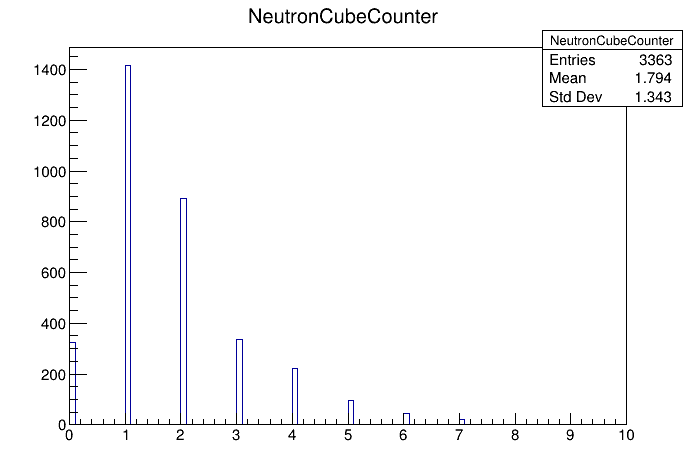

In [31]:
TCanvas c;
auto hist = df5.Histo1D({"NeutronCubeCounter", "NeutronCubeCounter", 100u, 0., 10}, "NeutronCubeCounter")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [32]:
df5 = df5.Filter("NeutronCubeCounter == 0");

In [33]:
double WithoutNoiseEvent = df5.Count().GetValue()

(double) 326.00000


In [34]:
WithoutNoiseEvent * 100. / totalEvent

(double) 0.16595652


In [35]:
// ROOT::RDF::SaveGraph(df4, "./firstFilterCutTree.dot");

# Distance Neutron COM and CE cube

In [36]:
ROOT::RDF::RNode dfdistance = df5.Define("NeutronCoM", "centerOfMass(volidNeutronCut, edep_pvtNeutronCut)");

In [37]:
dfdistance = dfdistance.Filter("NeutronCoM  != -1").Define("DistCENeutronCOM", "euclidDist(NeutronCoM, CEVolidRef)");

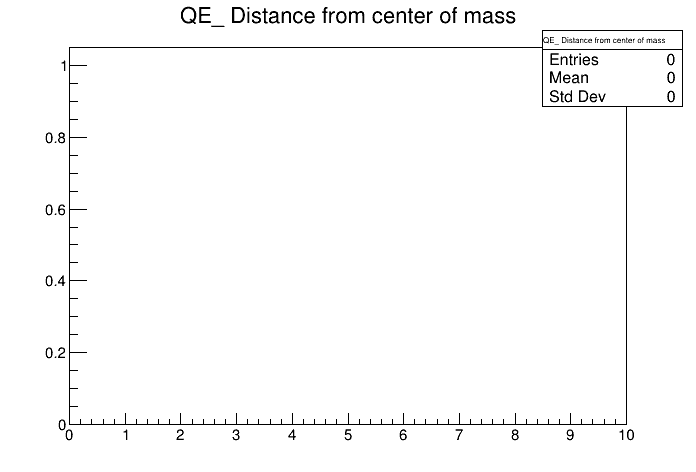

In [38]:
TCanvas c;
TObject* hist = dfdistance.Histo1D(
    {"QE_ Distance from center of mass", "QE_ Distance from center of mass", 200u, 0., 10.},
    "DistCENeutronCOM"
)->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronChainDistFromCoM"};
//savePlot(hist, dir, file);

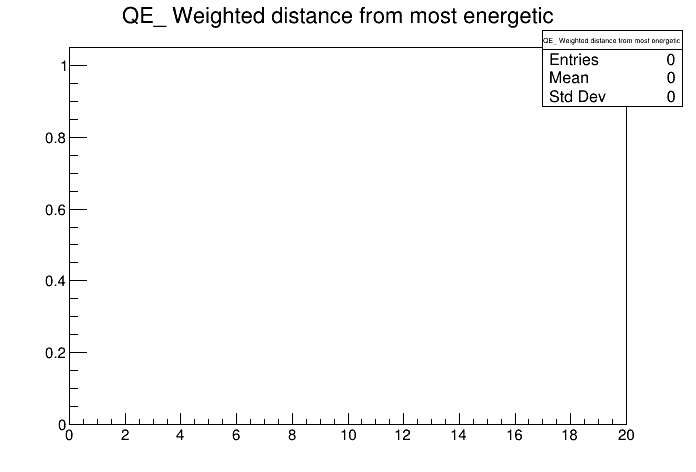

In [39]:
TCanvas c;
auto hist = dfdistance.Histo1D<ROOT::RVec<double>, ROOT::RVec<double>>(
    {"QE_ Weighted distance from most energetic", "QE_ Weighted distance from most energetic", 20u, 0., 20.0},
    "DistCENeutronCOM", "edep_pvtNeutronCut"
)->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronChainWDistFromMaxE"};
//savePlot(hist, dir, file);

In [40]:
dfdistance = dfdistance.Define("DistGNeutronCOM", "euclidDist(NeutronCoM, GammaVolidRef)");

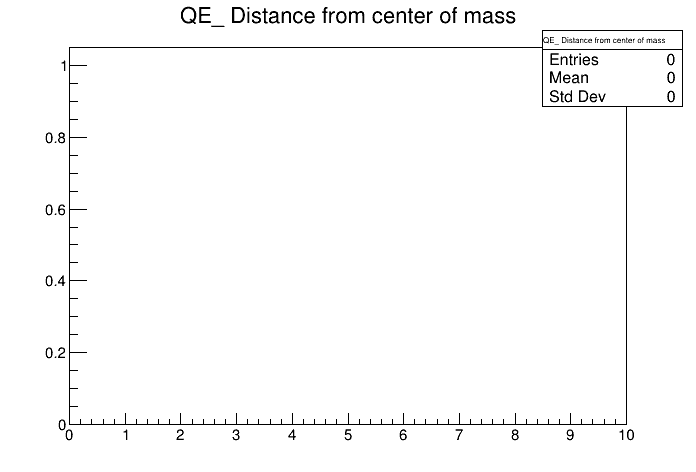

In [41]:
TCanvas c;
TObject* hist = dfdistance.Histo1D(
    {"QE_ Distance from center of mass", "QE_ Distance from center of mass", 200u, 0., 10.},
    "DistGNeutronCOM"
)->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronChainDistFromCoM"};
//savePlot(hist, dir, file);